



Importamos funciones

### Nota:
El documento está dividido en 2 partes. La primera es una implementación del algoritmo basado en un paper en donde se generaban grafos aleatoriamente. La segunda es una implementación del equipo UC-COVID en donde se implementa esta misma función, pero basada en ideas propias y bases de datos de redes de calles de USA.

# Parte 1

In [2]:
import os
import sys
#from ipynb.fs.full.Robustez import get_size_robust
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [3]:
from collections import deque
import random

Leemos grafo

In [4]:
path_geom = '../data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path_geom, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
     
path = '../data/corrected_dijkstra.csv'
path = path_geom
csv_grafo = pd.read_csv(path, sep=';') #, sep=','

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

Tree = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        Tree.add_edge(id_[origin], id_[dest])
        
G_SP = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G_SP.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Obtenemos carácterísticas del grafo

## Algoritmo
Parámetros iniciales

In [4]:
J = N
J = 30 # N
O = deque([0], int(1e6)) #0 es WTF
S = 0
#F_l = #largo de calles
#P_n = # cantidad de salidas desde el nodo
G = nx.DiGraph()
l = 0

Main loop

In [5]:
while True:
    # Parámetros
    J = N
    J = 40 # N
    O = deque([0], int(1e4)) #0 es WTF
    S = 0
    F_l = list(range(1,6)) # Largo de las calles
    P_n = [1, 1, 1, 1, 2, 2, 3, 3, 4] # cantidad de salidas desde el nodo
    G = nx.DiGraph()
    l = 0
    
    # Main loop
    while O: 
        # nts: next_tree_segment
        nts = O.popleft()
        growth = random.choice(P_n) 
        lenght_ = random.sample(F_l, growth)
        
        for i in range(1, growth + 1):
            G.add_edge(l + i, nts, length = lenght_[i - 1])
            O.append(l+i)
            
        l += growth
        S += growth
        
        
        if S >= J:
            break
    
    if len(G.nodes()) > J:
        break

In [6]:
len(G.nodes())

41

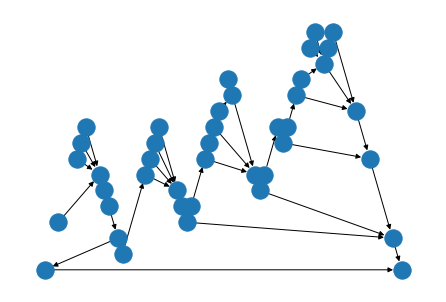

In [7]:
layout = nx.planar_layout(G)
nx.draw(G, pos = layout, with_labels = False )

In [8]:
max_depth = 15
T = Tree.subgraph([node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth])
print(len(T.nodes()))

42


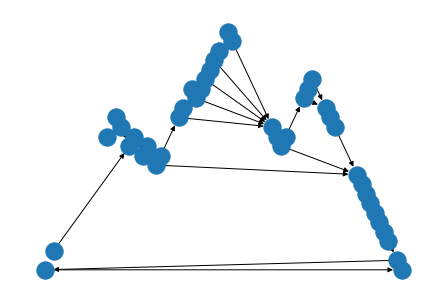

In [9]:
layout = nx.planar_layout(T)
nx.draw(T, pos = layout, with_labels = False )

# Parte 2
## USA data
### Algoritmo propio

Leemos grafo desde base de datos

In [38]:
path_nodes = '../data_random/TG.txt'
nodes_location = pd.read_csv(path_nodes, sep=" ", header=None, names = ['ID', 'Longitude', 'Latitude'])
path_edges = '../data_random/TG_edge.txt'
edges_location = pd.read_csv(path_edges, sep=" ", header=None, names = ['edge_ID', 'ID_1', 'ID_2', 'Distance'])
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


In [39]:
S = set()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

        
G_SJ = nx.Graph()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    G_SJ.add_edge(id_[origin], id_[dest])
    
N_ = l

Ploteamos el grado de los nodos del grafo

<AxesSubplot:>

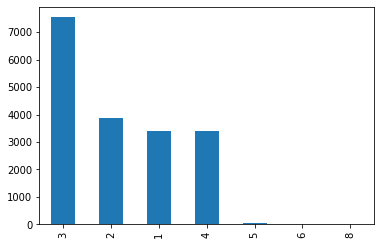

In [12]:
freq = [len(list(G_SJ.neighbors(i) )) for i in range(len(G_SJ.nodes()))]
pd.Series(freq).value_counts().plot(kind='bar')

Función get_closest retorna los $q$ nodos más cercanos al grafo que sean vecinos en el grafo original

In [17]:
def by_distance(element):
    return element[1]


def get_closest(G, locations, node, q):
    # get position of node
    x = locations[locations['ID'] == _id[node]]['Longitude'].iloc[0]
    y = locations[locations['ID'] == _id[node]]['Latitude'].iloc[0]
    
    #Neighbors
    ng = list(G.neighbors(node))
    
    # Calculate distances
    distances = list()
    for n in ng:
        n_id = _id[n]
        x_row = locations[locations['ID'] == n_id]['Longitude'].iloc[0]
        y_row = locations[locations['ID'] == n_id]['Latitude'].iloc[0]
        d = (x - x_row)**2 + (y - y_row)**2
        distances.append((n, d))
    
    # Order by distance and return q closest
    distances.sort(key = by_distance)    
    return [i[0] for i in distances[:q]] 

get_random_tree recibe un grafo G y una cantidad de nodos y retorna un árbol. Para esto hace una especie de bfs en donde se le hace un shuffle en cada iteración a la cola de hijos. De está forma se van agregando nodos hasta cumplir el límite.

add_extra_edges agrega aristas extras que perturban un árbol. Para esto selecciona al azar cierta cantidad de nodos y si se puede y no se supera el edge limit entonces agrega aristas que estaban en el grafo original G pero no en árbol T. De lo contrario selecciona otro nodo para esto.

In [14]:
def get_random_tree(G, nodes):
    new_G = nx.DiGraph()
    N = len(G.nodes())
    WTP = random.choice(list(G.nodes()))
    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:
            random.shuffle(Q)
            u = Q.popleft()
            for v in G.neighbors(u):
                if not V[v]:
                    Q.append(v)
                    new_G.add_edge(v,u)
                    V[v] = 1
        else:
            break
    return new_G, WTP

def add_extra_edges(T, G, locations, ratio, edge_limit):
    nodes = list(T.nodes())
    counter = 0
    perturbed = random.choices(nodes, k = math.ceil(len(nodes) * ratio))
    for node in perturbed:
        added = False
        if len(list(T.predecessors(node))) < edge_limit:
            closest = [i for i in get_closest(G, locations, node, 7) if i in nodes]
            if closest:
                closest = closest[0]
                T_neigbors = list(T.predecessors(node)) + list(T.successors(node))
                if len(list(T.predecessors(closest))) < edge_limit and  closest not in T_neigbors:
                    T.add_edge(node, closest)
                    added = True
                    #print('added')
        if not added and counter < len(nodes):
            perturbed.append(random.choice(nodes))
            counter += 1
    return T


In [15]:
def generate_random_graph(G, nodes, locations, ratio, edge_limit):
    T, WTP = get_random_tree(G, nodes)
    NG = add_extra_edges(T,G, locations, ratio, edge_limit)
    return NG, WTP
        

Ejemplos

11

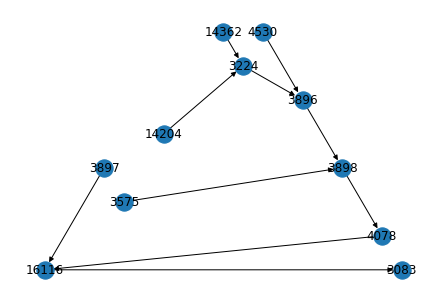

In [16]:
#U = nx.complete_graph(8)

G = G_SJ

R, _ = get_random_tree(G_SJ, 10)
R = add_extra_edges(R,G, nodes_location, 0.4, 5)
layout = nx.planar_layout(R)
nx.draw(R, pos = layout, with_labels = True)
len(R.nodes())

11

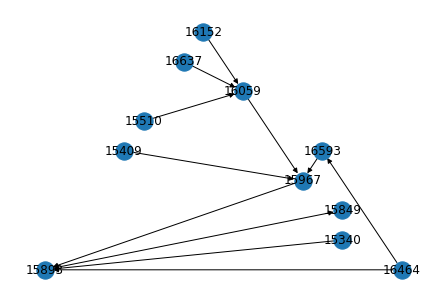

In [17]:
G_ , _ = generate_random_graph(G_SJ, 10, nodes_location, 0.5, 4)
layout = nx.planar_layout(G_)
nx.draw(G_, pos = layout, with_labels = True)
len(G_.nodes())

## Visualización de resultados

In [18]:
from shapely.geometry import LineString, Point

In [19]:
# geometry.head()
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


Primero obtenemos localizaciones de cada nodo y los asociamos a sus respectivas aristas

In [21]:
def get_location_node(locations, node):
    x = locations[locations['ID'] == node]['Longitude'].iloc[0]
    y = locations[locations['ID'] == node]['Latitude'].iloc[0]
    return x,y

def create_linestring(row, locations):
    node_1 = row['ID_1']
    node_2 = row['ID_2']
    x_1, y_1 = get_location_node(locations, node_1)
    x_2, y_2 = get_location_node(locations, node_2)
    return LineString([ (x_1, y_1) , (x_2, y_2)])

In [21]:
edges_location['geometry'] = edges_location.apply(lambda row: create_linestring(row, nodes_location), axis = 1)

In [22]:
edges_location.head()

,edge_ID,ID_1,ID_2,Distance,geometry
0,0,0,7388,1.410871,"LINESTRING (2418.382812 689.4497679999999, 241..."
1,1,0,5744,1.069441,"LINESTRING (2418.382812 689.4497679999999, 241..."
2,2,0,5835,34.071991,"LINESTRING (2418.382812 689.4497679999999, 238..."
3,3,0,3647,14.796446,"LINESTRING (2418.382812 689.4497679999999, 241..."
4,4,1,4232,136.073166,"LINESTRING (5983.526367 3650.609131, 6024.6494..."


In [23]:
# edges_location['edge'] = edges_location.apply(lambda row: (row['ID_1'], row['ID_2']), axis=1 )
# edges_location['edge_'] = edges_location.apply(lambda row: (row['ID_2'], row['ID_1']), axis=1 )

In [24]:
edges_location.head()
df = gpd.GeoDataFrame(edges_location['geometry'])

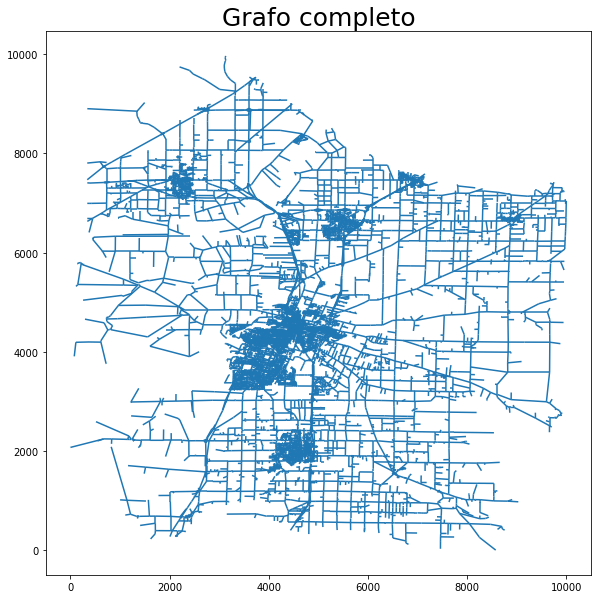

In [25]:
f, ax = plt.subplots(figsize=(10,10 ))
ax.set_title("Grafo completo", fontsize=25)
ax = df.plot(ax = ax, 
                   figsize=(10, 10),
                   legend = True)

plt.show()

In [26]:
def filter_(G, row):
    return row['edge'].isin(list(G.edges() )) #or row['edge_'].isin(list(G.edges() )) 


def plot_random_graph(G, edges_location, nodes_location, WTP):
    # Armamos listas de extremos de vertices
    G_id1 = [edge[0] for edge in G.edges()]
    G_id2 = [edge[1] for edge in G.edges()]
    #d = {(u,v) for u,v in G.edges()}
    pd.options.mode.chained_assignment = None  # default='warn'
    filtered = edges_location.loc[(edges_location['ID_1'].isin(G_id1)) & (edges_location['ID_2'].isin(G_id2))]

    # Filtramos elementos que están contenidos
    #filtered = edges_location.loc[lambda row: filter_(G, row) ]

    #filtered = edges_location.loc[edges_location['edge'] in d ]
    #filtered = filtered[(filtered['edge'] in d) & (filtered['edge_'] in d)]
    
    filtered.loc[filtered.shape[0] + 1] = ['WTP'] + ['WTP'] + ['WTP'] + ['WTP'] + [Point(get_location_node(nodes_location, WTP), 10)] 

# PLOT NODES
#     nodes = list(G.nodes())
#     for i in range(len(G.nodes())):
#         node = nodes[i]
#         if node in list(filtered['ID_1']) or node in list(filtered['ID_2']):
#              filtered.loc[filtered.shape[0] + 2 + i] = ['node'] + ['node'] + ['node'] + ['node'] + [Point(get_location_node(nodes_location, node), 1)] + ['node'] * 2

    # Graficamos
    df = gpd.GeoDataFrame(filtered['geometry'])
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Visualizacion grafo aleatorio", fontsize=25)
    ax = df.plot(ax = ax, 
                       figsize=(10, 10),
                       legend = True)
    plt.show()        
    

In [113]:
def plot_random_graph2(G, edges_location, nodes_location, WTP, nodes_size=0):

    filtro = []
    for index, row in edges_location.iterrows():
        filtro.append(((row['ID_1'], row['ID_2']) in G.edges()) or (row['ID_2'], row['ID_1']) in G.edges())
    
    filtro = pd.Series(filtro)

    pd.options.mode.chained_assignment = None  # default='warn'
    filtered = edges_location.loc[filtro]
    
    # filtered.loc[filtered.shape[0] + 1] = ['WTP'] + ['WTP'] + ['WTP'] + ['WTP'] + [Point(get_location_node(nodes_location, WTP), 10)] 

    
    # filtered.loc[filtered.shape[0] + 1] = ['WTP'] + ['WTP'] + ['WTP'] + ['WTP'] + [Point(get_location_node(nodes_location, WTP), 10)] 

    # PLOT NODES
    if nodes_size:
        nodes = list(G.nodes())
        for i in range(len(G.nodes())):
            node = nodes[i]
            filtered.loc[filtered.shape[0] + 2 + i] = ['node'] + ['node'] + ['node'] + ['node'] + [Point(get_location_node(nodes_location, node), nodes_size)]


    # Graficamos
    df = gpd.GeoDataFrame(filtered['geometry'])
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Visualizacion grafo aleatorio", fontsize=25)
    ax = df.plot(ax = ax, 
                       figsize=(10, 10),
                       legend = True)
    plt.show()        

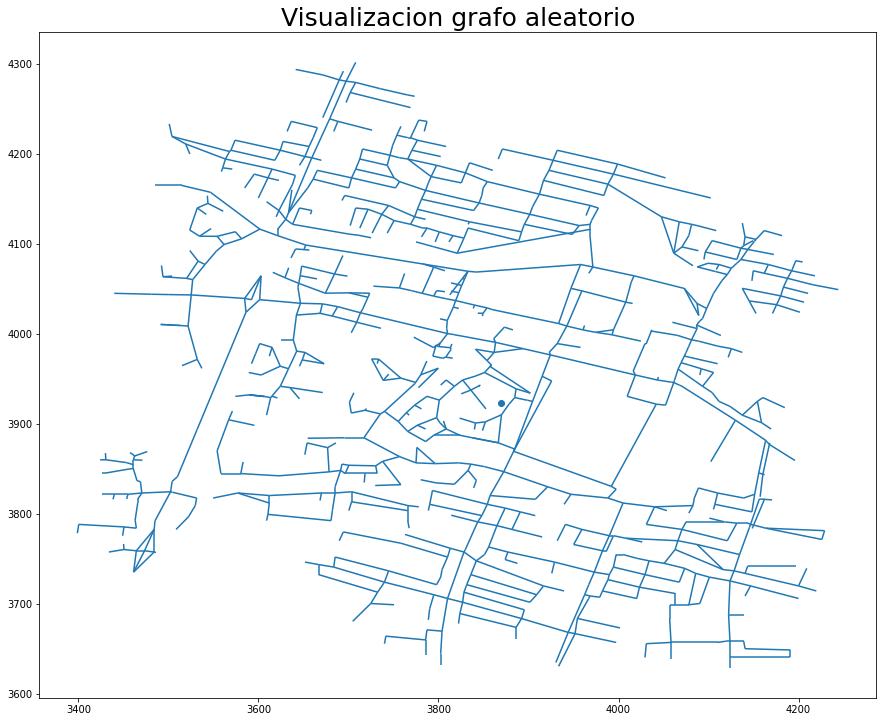

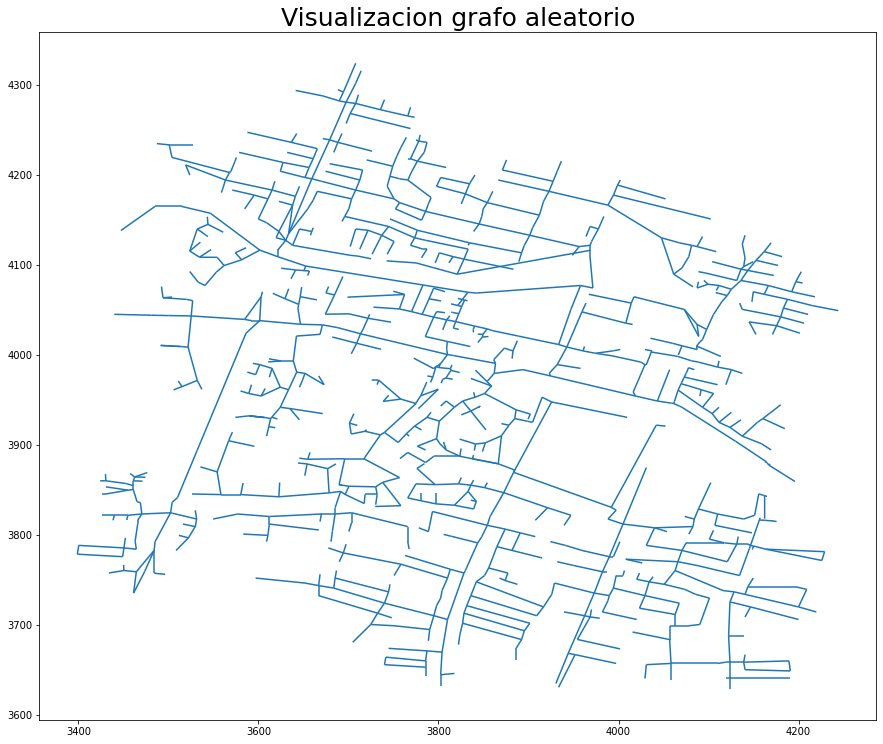

In [90]:
G = G_SJ

g, WTP = generate_random_graph(G_SJ, 1000, nodes_location, 0.05, 5)
plot_random_graph(g, edges_location, nodes_location, WTP)
plot_random_graph2(g, edges_location, nodes_location, WTP)

In [29]:
try:
    print(nx.find_cycle(g.to_undirected()))
except:
    print('no hay ciclos')

print(nx.is_connected(g.to_undirected()))

[(10268, 10324), (10324, 10936), (10936, 10973), (10973, 11114), (11114, 10268)]
True


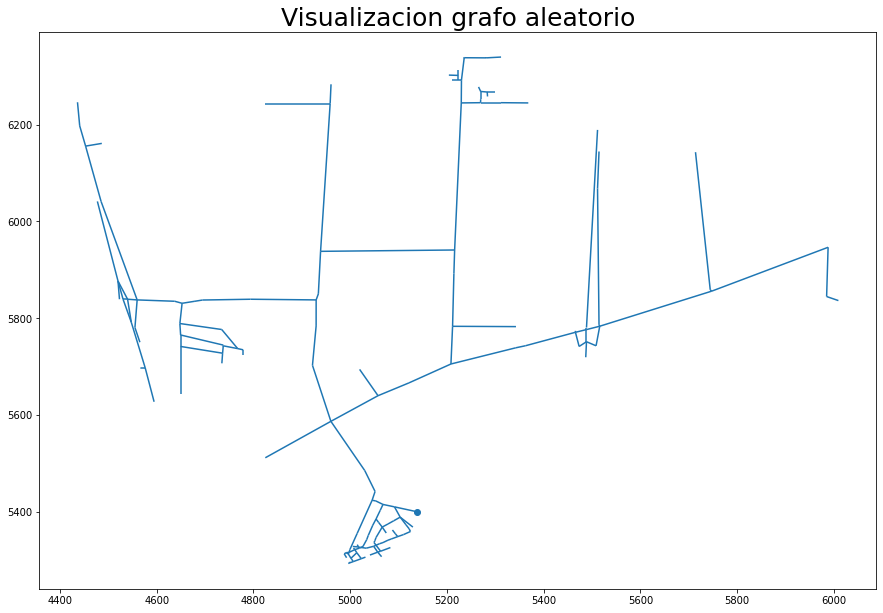

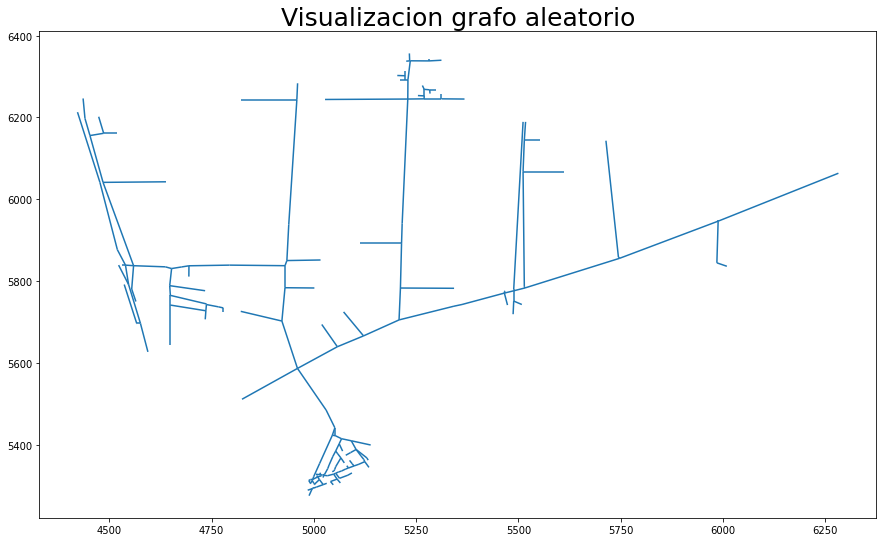

/home/benjar/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


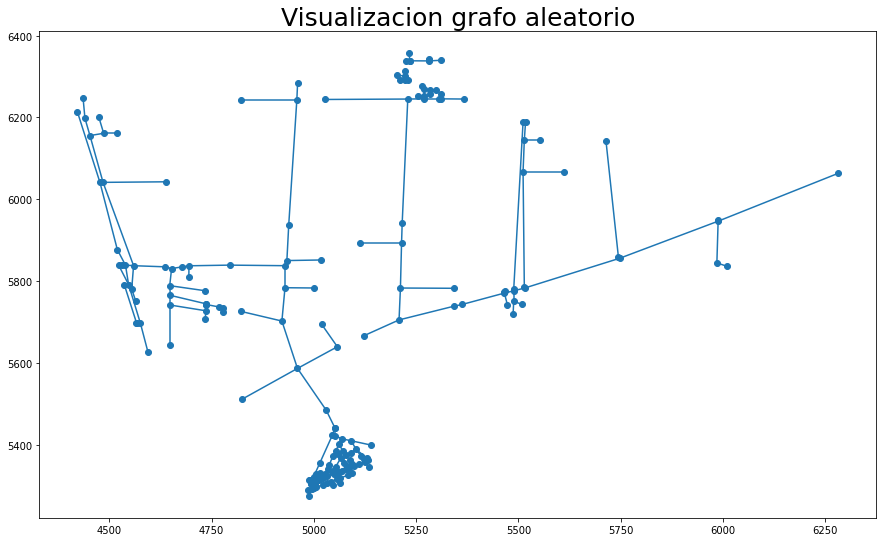

In [88]:
T, WTP = get_random_tree(G_SJ, 200)
plot_random_graph(T, edges_location, nodes_location, WTP)
plot_random_graph2(T, edges_location, nodes_location, WTP)
plot_random_graph2(T, edges_location, nodes_location, WTP, 0.1)

In [29]:
try:
    print(nx.find_cycle(T.to_undirected()))
except:
    print('no hay ciclos')

no hay ciclos


## Comparación de robustes de ideales en grafos reales y aleatorios

In [31]:
# Idea: para todo nodo registrar el porcentaje de variación entre su ideal normal y robusto
# Se grafica la distribución. Junto con eso, se registra el promedio
# Se hace lo mismo en la instancia real y en la aleatoria. Se comparan resultados.
def get_size_robust(G, V_, node):
    N = len(V_)
    if V_[node]:
        return 0
    if node == root:
        return N - sum(V_)
    V = [0] * N
    V[root] = 1; Q = deque([root])
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)
    return sum([1 for u in range(N) if V_[u] + V[u] == 0])

### Diferencias de ideales porcentualmente en grafo original

In [32]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

Promedio de tamano de ideal: 112


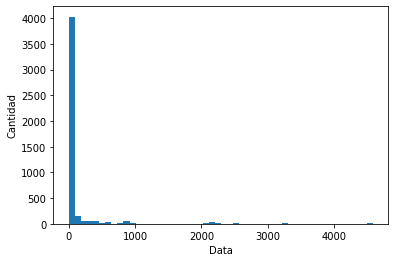

In [33]:
sizes = [get_size(G_SP, [0] * 5000, u) for u in G_SP.nodes()]
sizes.sort()
#pd.Series(sizes).value_counts().plot()
plt.hist(sizes, bins=50)
plt.ylabel('Cantidad')
plt.xlabel('Data')
print(f'Promedio de tamano de ideal: {round(sum(sizes)/len(sizes))}')

In [36]:
nodes_G = list(G_SP.nodes())
root = 744
N = len(nodes_G)
differences_original_1, differences_original_2, differences_original_3 = list(), list(), list()
differences_1, differences_2, differences_3 = split(sizes, 3)
for i in range(len(nodes_G)):
    node = nodes_G[i]
    size = get_size(G_SP, [0] * N , node)
    if size < max(differences_1):
        size_robust = get_size_robust(G_SP, [0] * N , node)
        differences_original_1.append(size_robust / size)
    elif size < max(differences_2):
        size_robust = get_size_robust(G_SP, [0] * N , node)
        differences_original_2.append(size_robust / size)
    else:
        size_robust = get_size_robust(G_SP, [0] * N , node)
        differences_original_3.append(size_robust / size)

Text(0.5, 0, 'Ratio')

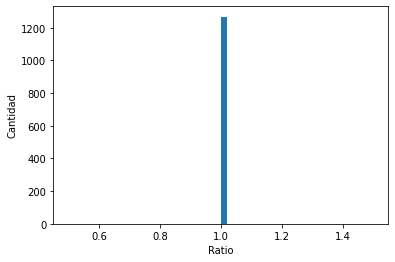

In [37]:
plt.hist(differences_original_1, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

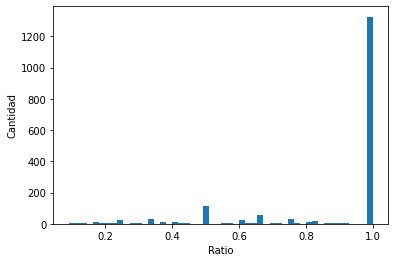

In [38]:
plt.hist(differences_original_2, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

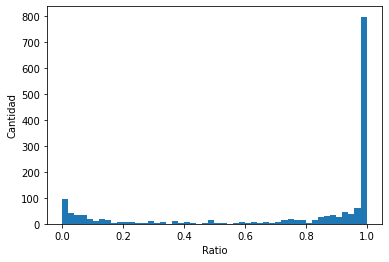

In [39]:
plt.hist(differences_original_3, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Distribuciones de grafo aleatorio

In [40]:
G_, WTP = generate_random_graph(G_SJ, len(G_SP.edges()), nodes_location, 0.05, 5)

/home/benjar/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


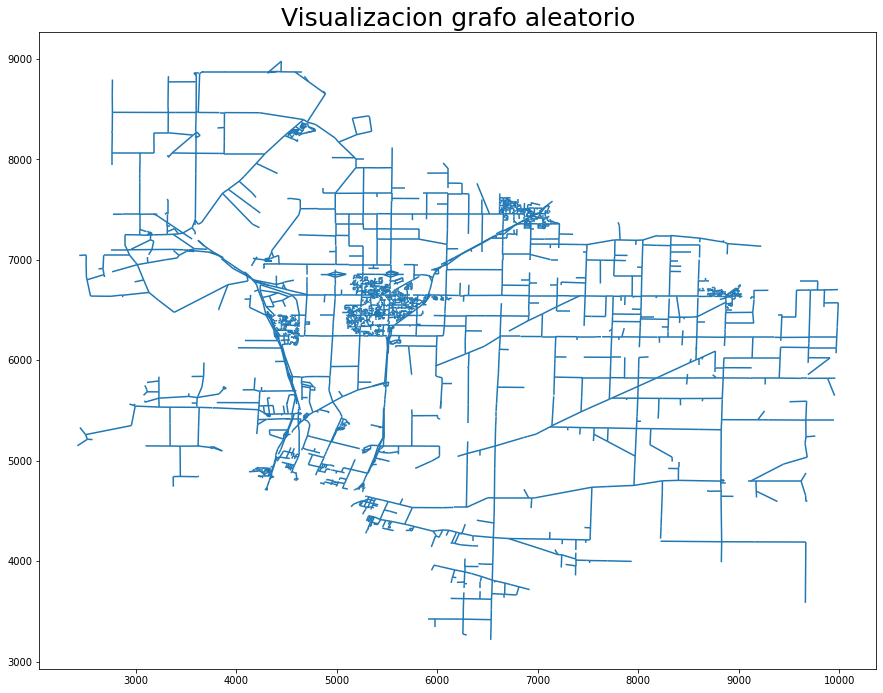

In [41]:
plot_random_graph(G_, edges_location, nodes_location, WTP)

In [42]:
G__ = G_.copy()
S = set()
for origin, dest in G__.edges():
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

        
G_ = nx.DiGraph()
for origin, dest in G__.edges():
    G_.add_edge(id_[origin], id_[dest])
    
Nr = l

Promedio de tamano de ideal: 44


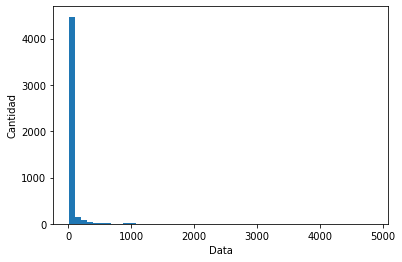

In [43]:
sizes = [get_size(G_, [0] * 20_000, u) for u in G_.nodes()]
sizes.sort()
#pd.Series(sizes).value_counts().plot()
plt.hist(sizes, bins=50)
plt.ylabel('Cantidad')
plt.xlabel('Data')
print(f'Promedio de tamano de ideal: {round(sum(sizes)/len(sizes))}')

In [44]:
nodes_Gr = list(G_.nodes())
Nr = len(nodes_Gr) 
root = id_[WTP]
differences_random = list()
differences_random_1, differences_random_2, differences_random_3 = list(), list(), list()
for i in range(len(nodes_Gr)):
    node = nodes_Gr[i]
    size = get_size(G_, [0] * Nr , node)
    size_robust =  get_size_robust(G_, [0] * Nr , node)
    if size < max(differences_1):
        differences_random_1.append(size_robust / size)
        
    elif size < max(differences_2):
        differences_random_2.append(size_robust / size)
        
    else:
        differences_random_3.append(size_robust / size)

Text(0.5, 0, 'Ratio')

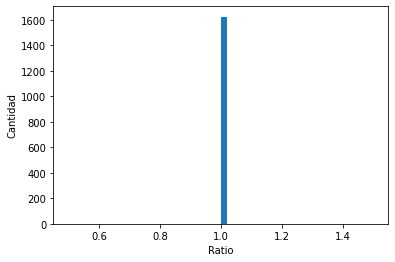

In [45]:
plt.hist(differences_random_1, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

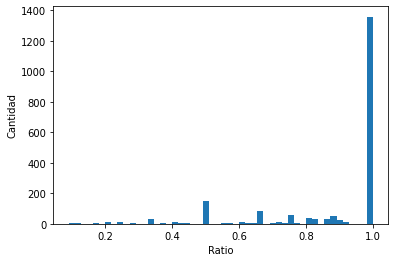

In [46]:
plt.hist(differences_random_2, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

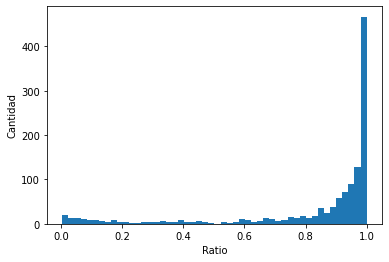

In [47]:
plt.hist(differences_random_3, bins=50)  
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

In [44]:
def create_linestring_coord(x_1, y_1, x_2, y_2):
    return LineString([(x_1, y_1) , (x_2, y_2)])

In [117]:
def get_random_tree_divide(G, nodes, mxl, nodes_location, edges_location):

    new_edges = edges_location.copy()
    new_nodes = nodes_location.copy()

    last_edge_id = int(new_edges.tail(1)['edge_ID'])
    last_node_id = max(max(new_edges['ID_1']), max(new_edges['ID_2']))

    new_G = nx.DiGraph()
    N = len(G.nodes())
    WTP = random.choice(list(G.nodes()))
    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:

            random.shuffle(Q)

            u = Q.popleft()
            xu, yu = get_location_node(nodes_location, u)

            for v in G.neighbors(u):
                if not V[v]:

                    Q.append(v); V[v] = 1
                    
                    xv, yv = get_location_node(nodes_location, v)
                    dist = np.sqrt((xu - xv) ** 2 + (yu - yv) ** 2)

                    xd, yd = (xu - xv) / dist, (yu - yv) / dist

                    while dist > mxl:

                        xvv, yvv = xv + xd * mxl, yv + yd * mxl
                        last_edge_id += 1
                        last_node_id += 1
                        new_G.add_edge(v, last_node_id)
                        new_edges = new_edges.append({'edge_ID': last_edge_id, 'ID_1': v, 'ID_2': last_node_id, 'Distance': mxl, 
                                                      'geometry': create_linestring_coord(xv, yv, xvv, yvv)}, ignore_index=True)
                        new_nodes = new_nodes.append({'ID': last_node_id, "Longitude": xvv, "Latitude": yvv}, ignore_index=True)

                        xv, yv = xvv, yvv
                        dist = np.sqrt((xu - xv) ** 2 + (yu - yv) ** 2)
                        v = last_node_id
                
                    last_edge_id += 1
                    new_G.add_edge(v, u)
                    new_edges = new_edges.append({'edge_ID': last_edge_id, 'ID_1': v, 'ID_2': u, 'Distance': dist, 
                                                  'geometry': create_linestring_coord(xv, yv, xu, yu)}, ignore_index=True)

        else:
            break

    return new_G, WTP, new_nodes, new_edges

In [125]:
T, WTP, new_nodes, new_edges = get_random_tree_divide(G_SJ, 1000, 250, nodes_location, edges_location)

1000


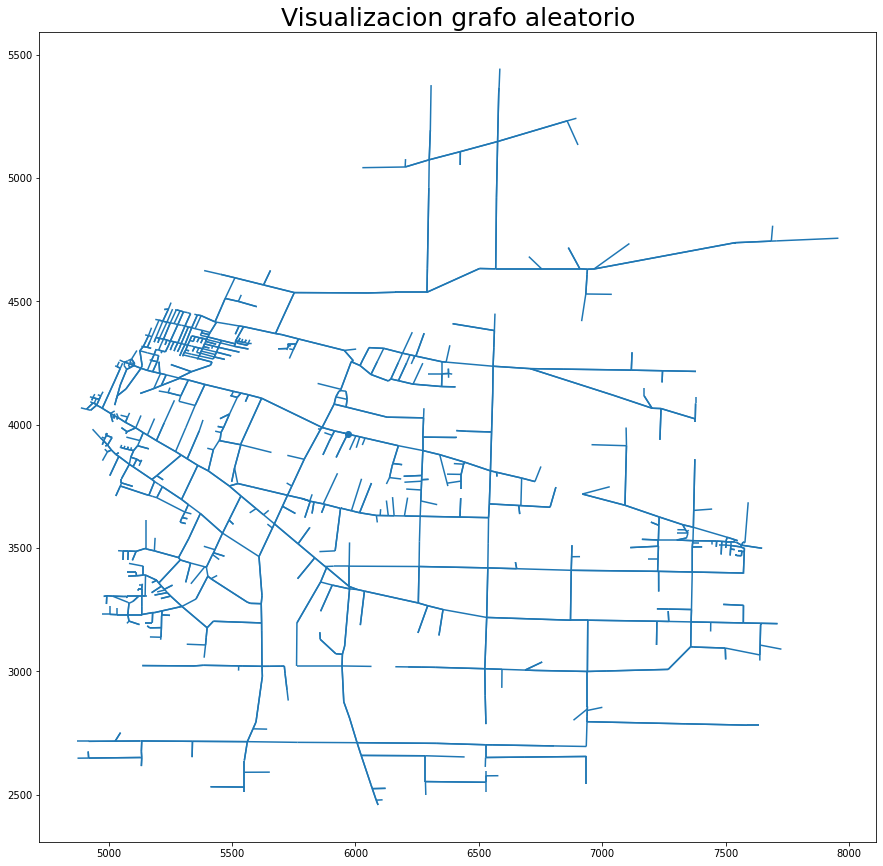

/home/benjar/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


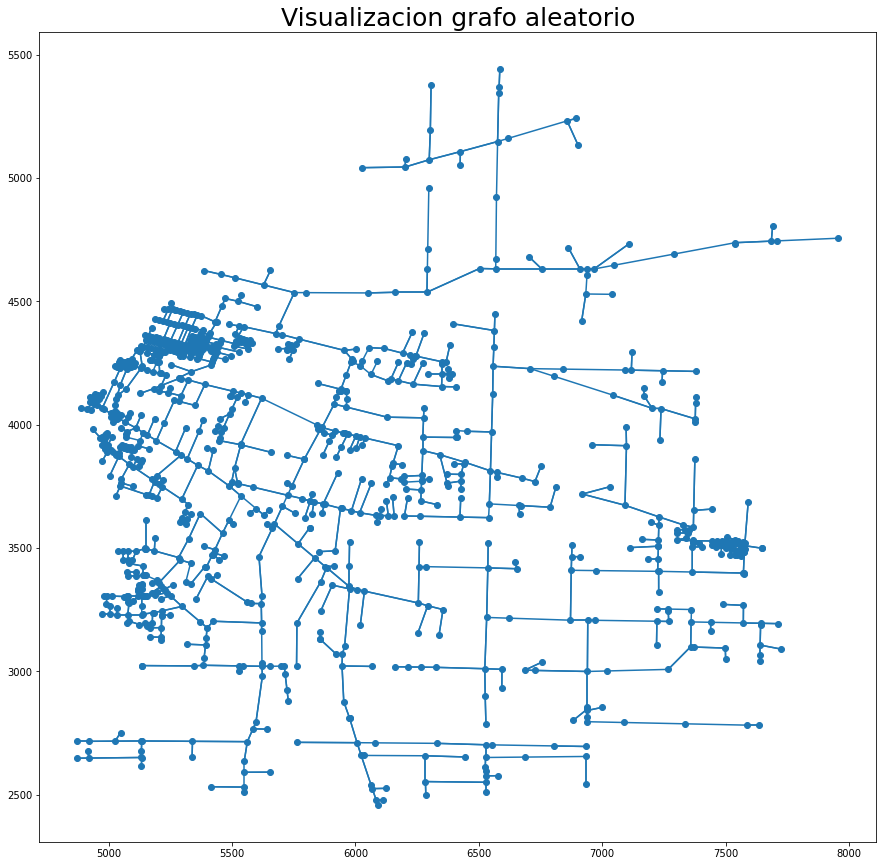

In [126]:
print(len(T.nodes()))
plot_random_graph(T, new_edges, new_nodes, WTP)
plot_random_graph2(T, new_edges, new_nodes, WTP, 0.1)

In [68]:
print(np.mean(edges_location['Distance']), np.std(edges_location['Distance']))

34.905461105721706 57.11357862604703


## Determinación de Water Treatment plants

Dada la ubicación aproximada de 3 plantas de tratamiento (WTP), queremos encontrar los nodos más cercanos a ellos

In [48]:
def get_closest_nodes(coordinates_list, nodes_locations):
    nodes = list()
    for x,y in coordinates_list:
    
        # Calculate distances
        distances = list()
        for i,row in nodes_locations.iterrows():
            n = row['ID']
            x_row = row['Longitude']
            y_row = row['Latitude']
            d = (x - x_row)**2 + (y - y_row)**2
            distances.append((n, d))

        # Order by distance and return q closest
        distances.sort(key = by_distance)    
        nodes.append(int(distances[0][0]))
    return nodes

In [49]:
# Coordenadas de WTP
coordinates_list = [(5000, 1500), (9700, 2500), (6000, 7000)] 
WTPs = get_closest_nodes(coordinates_list, nodes_location)

In [57]:
get_location_node(nodes_location, WTPs[1])
WTPs
[id_[int(i)] for i in WTPs]

[7139, 15952, 9155]

Los Id de los nodos de las plantas de tratamiento son: [7139, 15952, 9155]
